# Correlation Analysis Pipeline

1) Data loading
2) Data transform
3) Testing/plotting the data
4) Correlation tests

## 1) Data loading

In [1]:
import glob
# Imports and setup
import os

import pandas as pd

from correlation_analysis import (
    extract_symbol_from_filename,
    load_and_transform_file,
    resample_and_fill,
    calculate_correlation_with_timing,
)

# Paths
dataset_dir = 'dataset'
output_dir = 'clean_dataset/instrument_series'
os.makedirs(output_dir, exist_ok=True)

print('Setup complete')

Setup complete


In [2]:
# List dataset files
csv_files = sorted(glob.glob(os.path.join(dataset_dir, '*.csv')))
print(f'Found {len(csv_files)} CSV files')
csv_files[:5]

Found 81 CSV files


['dataset\\ABEV3_ticks.csv',
 'dataset\\ALOS3_ticks.csv',
 'dataset\\ASAI3_ticks.csv',
 'dataset\\AURE3_ticks.csv',
 'dataset\\AZZA3_ticks.csv']

## 2) Data transform

In [6]:
# Transform a sample instrument and save to output_dir
if not csv_files:
    print('No CSV files found in dataset/')
else:
    selected_file = csv_files[0]
    print(f'Selected file: {selected_file}')
    df_transformed = load_and_transform_file(selected_file)
    symbol = extract_symbol_from_filename(selected_file)
    output_path = os.path.join(output_dir, f'{symbol}_transformed.csv')
    df_transformed.to_csv(output_path, index=True)
    print(f'Saved transformed to: {output_path} | shape={df_transformed.shape}')
    df_transformed.head()

Selected file: dataset\ABEV3_ticks.csv
Processing ABEV3... ✅ 4,632,121 rows
Saved transformed to: clean_dataset/instrument_series\ABEV3_transformed.csv | shape=(4632121, 2)


## 3) Testing/plotting the data

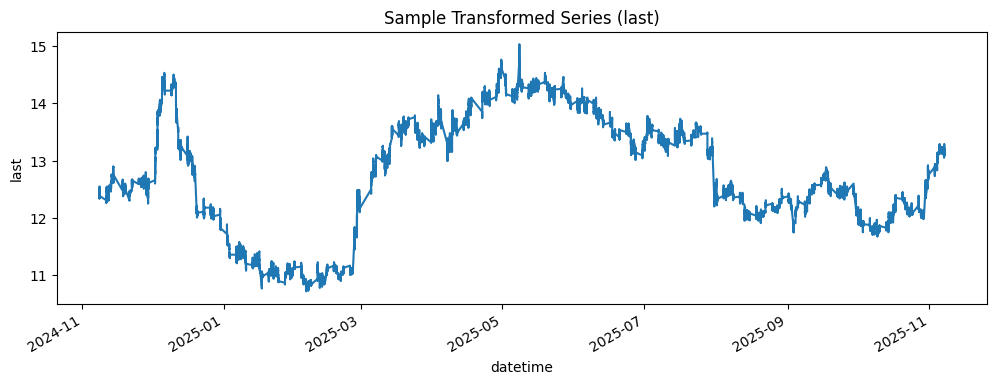

In [4]:
# Plot a sample transformed series
try:
    if 'df_transformed' not in locals():
        transformed_files = sorted(glob.glob(os.path.join(output_dir, '*_transformed.csv')))
        if transformed_files:
            df_transformed = pd.read_csv(transformed_files[0])
            df_transformed['datetime'] = pd.to_datetime(df_transformed['datetime'])
            df_transformed = df_transformed.set_index('datetime')
        elif csv_files:
            df_transformed = load_and_transform_file(csv_files[0])
        else:
            raise RuntimeError('No data available to plot')

    ax = df_transformed['last'].plot(figsize=(12, 4), title='Sample Transformed Series (last)')
    ax.set_xlabel('datetime')
    ax.set_ylabel('last')
except Exception as e:
    print(f'Plotting error: {e}')

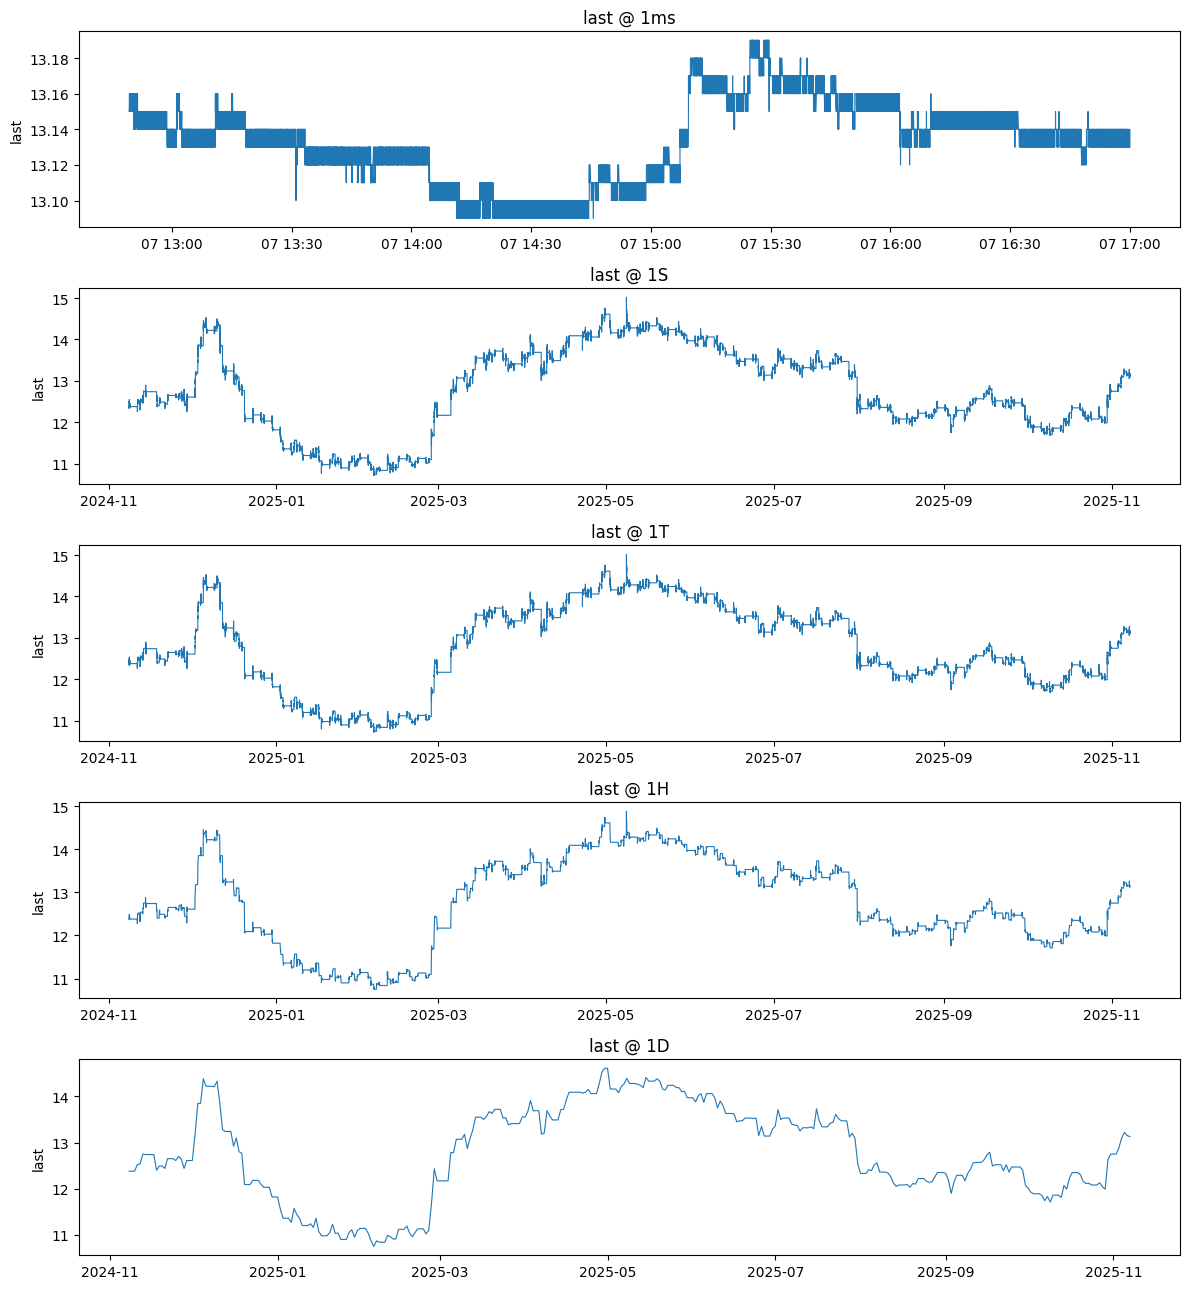

In [5]:
# Plot series at multiple frequencies (1ms, 1S, 1T, 1H, 1D)
import matplotlib.pyplot as plt

# Ensure we have a transformed DataFrame
if 'df_transformed' not in locals():
    transformed_files = sorted(glob.glob(os.path.join(output_dir, '*_transformed.csv')))
    if transformed_files:
        df_transformed = pd.read_csv(transformed_files[0])
        df_transformed['datetime'] = pd.to_datetime(df_transformed['datetime'])
        df_transformed = df_transformed.set_index('datetime')
    elif csv_files:
        df_transformed = load_and_transform_file(csv_files[0])
    else:
        raise RuntimeError('No data available to plot')

freqs = ['1ms', '1S', '1T', '1H', '1D']
fig, axes = plt.subplots(len(freqs), 1, figsize=(12, 2.6 * len(freqs)), sharex=False)
if len(freqs) == 1:
    axes = [axes]

for ax, f in zip(axes, freqs):
    try:
        df_plot = resample_and_fill(df_transformed[['last']], f)
        if f == '1ms' and len(df_plot) > 10000:
            df_plot = df_plot.tail(10000)
        ax.plot(df_plot.index, df_plot['last'], linewidth=0.8)
        ax.set_title(f'last @ {f}')
        ax.set_ylabel('last')
    except Exception as e:
        ax.text(0.01, 0.5, f'Error plotting {f}: {e}', transform=ax.transAxes)
        ax.set_axis_off()

plt.tight_layout()

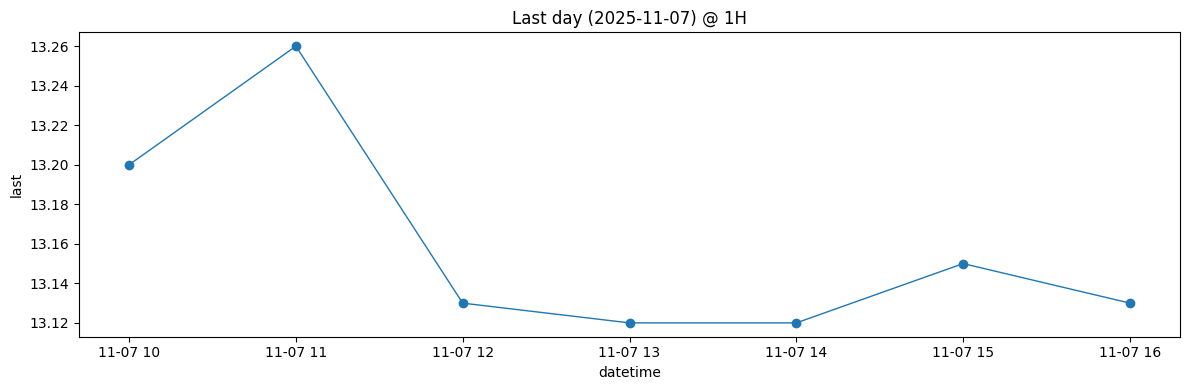

In [9]:
# Plot last day @ 1H
import matplotlib.pyplot as plt

# Ensure we have a transformed DataFrame
if 'df_transformed' not in locals():
    transformed_files = sorted(glob.glob(os.path.join(output_dir, '*_transformed.csv')))
    if transformed_files:
        df_transformed = pd.read_csv(transformed_files[0])
        df_transformed['datetime'] = pd.to_datetime(df_transformed['datetime'])
        df_transformed = df_transformed.set_index('datetime')
    elif csv_files:
        df_transformed = load_and_transform_file(csv_files[0])
    else:
        raise RuntimeError('No data available to plot')

# Compute last available day window
last_start = df_transformed.index.max().floor('D')
last_end = last_start + pd.Timedelta(days=1)
mask = (df_transformed.index >= last_start) & (df_transformed.index < last_end)
df_last_day = df_transformed.loc[mask]

# Fallback: if the very last day has no rows (e.g., partial trailing day), take previous day
if df_last_day.empty:
    prev_start = (df_transformed.index.max() - pd.Timedelta(days=1)).floor('D')
    prev_end = prev_start + pd.Timedelta(days=1)
    df_last_day = df_transformed.loc[(df_transformed.index >= prev_start) & (df_transformed.index < prev_end)]
    last_start = prev_start

# Resample to 1H
try:
    df_1h = resample_and_fill(df_last_day[['last']], '1H')
except Exception:
    df_1h = df_last_day[['last']].resample('1H').last().ffill()

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df_1h.index, df_1h['last'], marker='o', linewidth=1)
ax.set_title(f'Last day ({last_start.date()}) @ 1H')
ax.set_xlabel('datetime')
ax.set_ylabel('last')
plt.tight_layout()

## 4) Correlation tests

In [8]:
# Run correlation tests on two instruments
from pathlib import Path

# Ensure we have at least two transformed instruments
transformed_files = sorted(glob.glob(os.path.join(output_dir, '*_transformed.csv')))

if len(transformed_files) < 2:
    # Transform first two raw files if needed
    print("entrou aqui")
    if len(csv_files) < 2:
        raise RuntimeError('Need at least two CSVs in dataset/ to run correlation tests')
    for raw_path in csv_files[:2]:
        df_tmp = load_and_transform_file(raw_path)
        sym = extract_symbol_from_filename(raw_path)
        df_tmp.to_csv(os.path.join(output_dir, f'{sym}_transformed.csv'))
    transformed_files = sorted(glob.glob(os.path.join(output_dir, '*_transformed.csv')))

# Pick first two instruments
inst1 = Path(transformed_files[0]).stem.replace('_transformed', '')
inst2 = Path(transformed_files[1]).stem.replace('_transformed', '')
print(f'Testing pair: {inst1} vs {inst2}')

frequencies = ['1ms', '1S', '1T']
methods = ['pearson', 'spearman', 'kendall']

results = []
for f in frequencies:
    for m in methods:
        corr, exec_time = calculate_correlation_with_timing(inst1, inst2, f, m)
        results.append({
            'instrument1': inst1,
            'instrument2': inst2,
            'frequency': f,
            'method': m,
            'correlation': corr,
            'time_sec': exec_time,
        })

pd.DataFrame(results)

Testing pair: ABEV3 vs ALOS3


,instrument1,instrument2,frequency,method,correlation,time_sec
0,ABEV3,ALOS3,1ms,pearson,0.174593,7.643511
1,ABEV3,ALOS3,1ms,spearman,0.209196,7.367324
2,ABEV3,ALOS3,1ms,kendall,0.120511,7.299842
3,ABEV3,ALOS3,1S,pearson,0.138399,16.749189
4,ABEV3,ALOS3,1S,spearman,0.126414,18.925552
5,ABEV3,ALOS3,1S,kendall,0.058133,18.104081
6,ABEV3,ALOS3,1T,pearson,0.138392,5.562515
7,ABEV3,ALOS3,1T,spearman,0.126396,5.597345
8,ABEV3,ALOS3,1T,kendall,0.058119,5.514331


In [ ]:
import pandas as pd

# Define frequencies with pandas-compatible aliases
# Note: ms=milliseconds, S=seconds, T=minutes, H=hours
frequencies = [
    '1ms', '5ms', '10ms', '20ms', '50ms', '100ms', '200ms', '500ms',
    '1S', '5S', '10S', '30S',
    '1T', '5T', '15T', '30T',
    '1H'
]

data = []

print("Generating POC combinations for PETR3 vs VALE3...")

for freq in frequencies:
    # Repeat each frequency 20 times (creating 20 separate lines)
    for i in range(20):
        data.append({
            'instrument1': 'PETR3',
            'instrument2': 'VALE3',
            'period': '1Year',
            'frequency': freq,
            'correlation': 'pearson',
            'repeat': 1  # Each line is one run
        })

# Create DataFrame and save to CSV
df = pd.DataFrame(data)
output_file = 'poc_combinations.csv'
df.to_csv(output_file, index=False)

print(f"✅ Successfully generated {len(df)} combinations in '{output_file}'")
print(f"Total Frequencies: {len(frequencies)}")
print(f"Total Rows: {len(df)}")